In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from collections import deque
import enum
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import time


import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)


def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
                [1.9, -0.3, -2],
                [-0.3,    0, -0.3],
                [-2, -0.3, 1.9]
    ])
    display(conf_matrix)
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[0]) + np.sum(conf_matrix[2])
    
    result = hit_matrix_sum / np.sqrt(action_count)
    return result




# 2. Грузим df фичей

In [2]:
merged_data = pd.read_csv("/Users/rs/Documents/HFT project/merged_data.csv")

In [4]:
merged_data

,local_ts,imb_futures,imb_spot,vwap_futures,vwap_spot,futures_sell_trades_total_vol,futures_buy_trades_total_vol,spot_sell_trades_total_vol,spot_buy_trades_total_vol,trades_ratio_futures_10sec,trades_ratio_spot_10sec,div,mean_div,last_pret_futures,last_pret_spot,pret_futures,pret_spot,ADL_10sec,vol,real_vol,Jump_var,target
0,1.679443e+18,-0.902361,NaN,NaN,NaN,0.004,0.000,0.00147,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0
1,1.679443e+18,-0.999873,0.313629,NaN,NaN,0.204,0.000,0.75245,0.02195,NaN,34.280182,-5.239118,-0.005513,0.0,0.000000,0.000000e+00,5.514861e-07,0.000000,0.000000,0.000000,0.000000,0
2,1.679443e+18,-0.979789,0.313629,NaN,NaN,0.204,0.000,0.75245,0.02195,NaN,34.280182,-5.239118,-0.002756,0.0,0.000000,-4.440892e-16,2.757431e-07,0.000000,0.000000,0.000000,0.000000,0
3,1.679443e+18,-0.999420,-0.095543,0.999960,1.000001,0.208,0.547,3.75332,3.52656,0.380256,1.064301,-5.137823,0.144684,0.0,-0.000084,-9.255683e-06,-2.373219e-05,-0.000006,0.126491,0.045029,0.000811,-1
4,1.679443e+18,-0.999024,-0.975859,0.999964,1.000004,0.208,3.234,4.36109,3.90044,0.064317,1.118102,-5.400976,-0.160198,0.0,0.000000,-6.941762e-06,9.086128e-06,-0.000097,0.132842,0.047290,0.000895,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4039342,1.684963e+18,0.573420,-0.667402,1.000000,0.999981,9.676,0.611,0.12284,0.21554,15.836334,0.569917,-6.467981,-0.018291,0.0,0.000000,-6.845809e-06,-5.015525e-06,-0.347742,0.643047,0.243595,0.023735,0
4039343,1.684963e+18,0.576635,-0.674735,1.000000,0.999988,9.726,0.613,0.12284,0.21118,15.866232,0.581684,-6.467981,-0.010490,0.0,0.000000,-5.982180e-06,-4.932494e-06,-0.350387,0.647058,0.245115,0.024032,0
4039344,1.684963e+18,0.572618,-0.674735,1.000000,0.999988,9.305,0.608,0.12109,0.20532,15.304276,0.589762,-6.467981,0.005117,0.0,0.000000,-4.318564e-06,-4.830648e-06,-0.352217,0.630840,0.238972,0.022843,0
4039345,1.684963e+18,0.575152,-0.675716,1.000001,0.999982,8.408,0.393,0.12857,0.20532,21.394402,0.626193,-6.467981,0.036913,0.0,0.000000,-9.927714e-07,-4.686528e-06,-0.352311,0.614152,0.232651,0.021651,0


# 3. Обучим модель

In [5]:
def lgbm_model_try(df_orig):
    
    df = df_orig.copy()
    X = df.drop(['target', 'local_ts'], axis=1)

    if np.isinf(X).any().any():
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X.fillna(0, inplace=True)

    y = df['target']
    y += 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    lgbm_model = lgb.LGBMClassifier(objective='multiclass', num_class=3)

    lgbm_params = {
        'n_estimators': [100],
        'max_depth': [4],
        'learning_rate': [0.2],
        'min_child_weight': [1],
        'colsample_bytree': [1.0],
        'reg_alpha': [0.0],
        'reg_lambda': [0.1]
    }

    lgbm_grid = GridSearchCV(lgbm_model, lgbm_params, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
    lgbm_grid.fit(X_train, y_train)

    best_model = lgbm_grid.best_estimator_
    lgb.plot_importance(best_model, max_num_features=20)

    best_model.booster_.save_model('model_lgb.txt')

    best_params = lgbm_grid.best_params_
    
    y_pred = lgbm_grid.predict(X_test)
    y_pred_prob = lgbm_grid.predict_proba(X_test)

    # y_pred_labels = [1 if row[2] > 0.5 else -1 if row[0] > 0.5 else 0 for row in y_pred_prob]
    y_pred_labels = np.argmax(y_pred_prob, axis=1)
    y_pred_labels -= 1

    y_test = y_test.values
    y_test -= 1
    
    print('accuracy_score: ', accuracy_score(y_test, y_pred_labels))
    confusion_mat = confusion_matrix(y_test, y_pred_labels)
    print(confusion_mat)
    print(metric(y_test, y_pred_labels))
    
    return best_model 

In [7]:
train_df = merged_data[:-200000]
val_df = merged_data.tail(200000)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
accuracy_score:  0.6355077465369572
[[ 79484 135936  39824]
 [ 33070 570430  35178]
 [ 42689 133127  82067]]


array([[ 79484, 135936,  39824],
       [ 33070, 570430,  35178],
       [ 42689, 133127,  82067]])

56.85601082098652
Execution time: 360.31 seconds


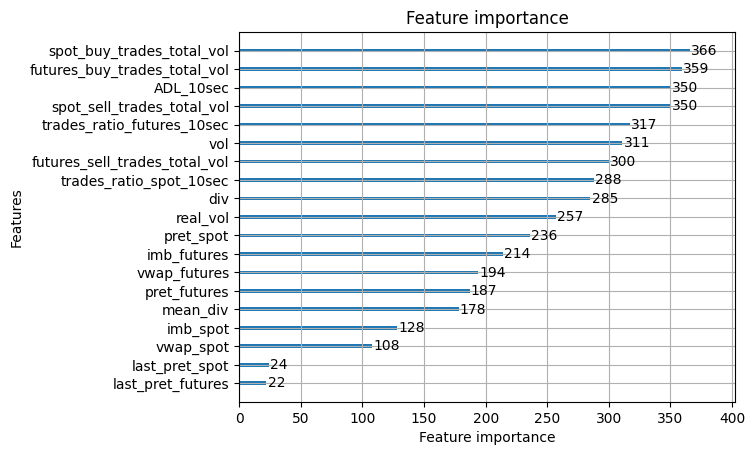

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.9min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.9min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.9min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.7min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 1.4min


In [8]:
start_time = time.time()
model_cv = lgbm_model_try(train_df)
end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

# 4. Создадим банчи по 1 млн для дообучения

In [70]:
def batch_generator(df, batch_size=1000000):
    num_samples = len(df)
    num_batches = int(np.ceil(num_samples / batch_size))
    start_idx = 0
    
    for batch_idx in range(num_batches):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_data = df.iloc[start_idx:end_idx]
        yield pd.DataFrame(batch_data)
        
        start_idx = end_idx


# 5. Дообучим модель

In [1]:
def lgbm_model_after_train(df_orig, init_model_name = 'model_lgb.txt',\
                           saved_model_name = 'model_lgbm_after_trained.txt'):
    
    df = df_orig.copy()
    X = df.drop(['target', 'local_ts'], axis=1)

    if np.isinf(X).any().any():
        X.replace([np.inf, -np.inf], np.nan, inplace=True)
        X.fillna(0, inplace=True)

    y = df['target']
    y += 1
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    loaded_model = lgb.Booster(model_file=init_model_name)

    train_data = lgb.Dataset(X_train, label=y_train, weight=3)
    
    lgb_params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'verbosity': -1 
    }

    best_model = lgb.train(lgb_params, train_set=train_data, init_model=loaded_model)

    lgb.plot_importance(best_model, max_num_features=20)

    best_model.save_model(saved_model_name)

    
    y_pred = best_model.predict(X_test)

    # y_pred_labels = [1 if row[2] > 0.5 else -1 if row[0] > 0.5 else 0 for row in y_pred_prob]
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_labels -= 1

    y_test = y_test.values
    y_test -= 1
    
    print('accuracy_score: ', accuracy_score(y_test, y_pred_labels))
    confusion_mat = confusion_matrix(y_test, y_pred_labels)
    print('metric: ',metric(y_test, y_pred_labels))
    print()
    return best_model 

In [2]:
generator = batch_generator(merged_data.iloc[:17000000], batch_size=3000000)

NameError: name 'batch_generator' is not defined

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
accuracy_score:  0.77048


array([[ 17507,  32253,    494],
       [  1548, 193114,   1646],
       [   648,  32267,  20523]])

metric:  154.21392650931932



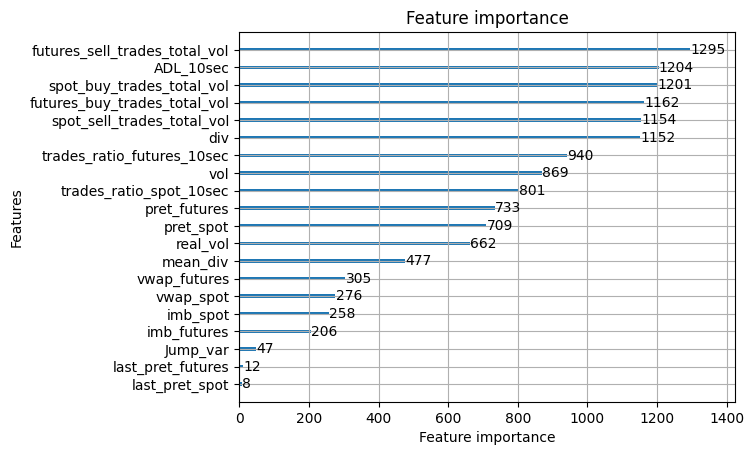

In [73]:
lgbm_model_after_train(next(generator), init_model_name = 'model_lgb.txt',\
                           saved_model_name = 'model_lgbm_after_trained.txt')

## 5.1 Обучаем все 20 млн

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.2min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.2min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.2min
accuracy_score:  0.7717266666666667


array([[ 16981,  30721,   1004],
       [  2613, 196008,   2431],
       [   867,  30846,  18529]])

metric:  139.06313131141636

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time= 2.0min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=4, min_child_weight=1, n_estimators=100, reg_alpha=0.0, reg_lambda=0.1; total time=  57.2s
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
accuracy_score:  0.7252866666666666


array([[82309, 12958, 15057],
       [11858, 67687, 10245],
       [18350, 13946, 67590]])

metric:  443.39786988065197

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
accuracy_score:  0.6429933333333333


array([[73282, 15940, 20194],
       [18518, 48619, 16281],
       [21277, 14892, 70997]])

metric:  368.5105330038445

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
accuracy_score:  0.7612566666666667


array([[ 24501,  27144,   3220],
       [  4620, 176991,   6179],
       [  2476,  27984,  26885]])

metric:  198.41117071515285

[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
accuracy_score:  0.855025


array([[ 10632,  13116,    157],
       [   983, 147214,   1806],
       [   208,  12725,  13159]])

metric:  160.48249394264695



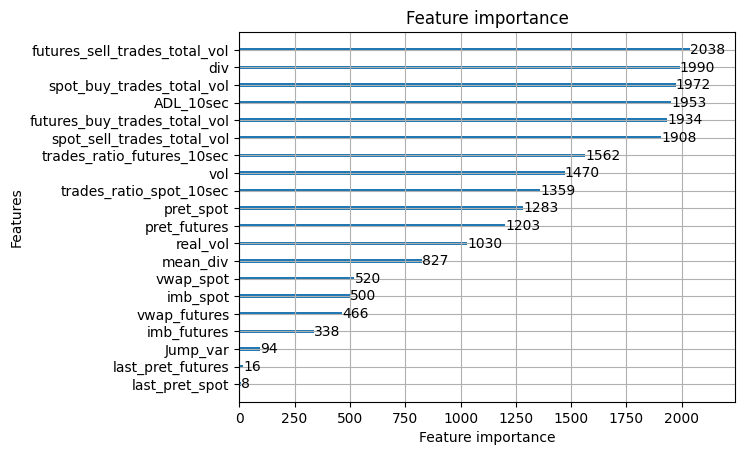

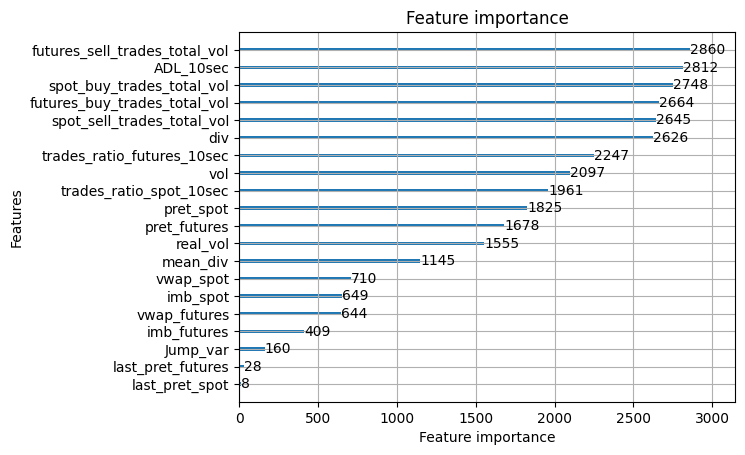

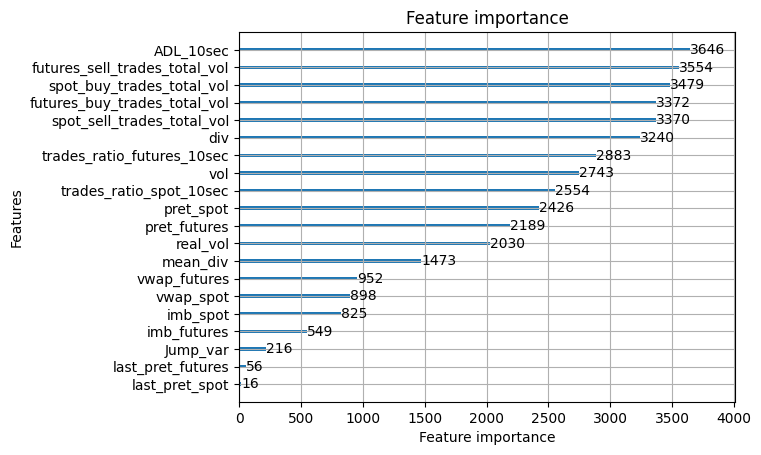

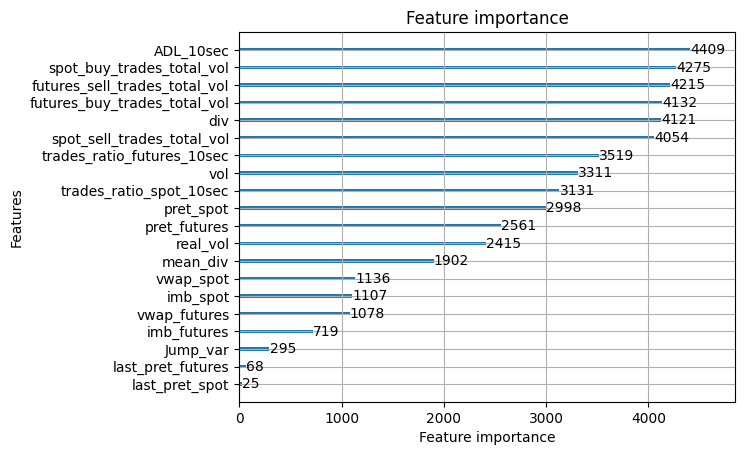

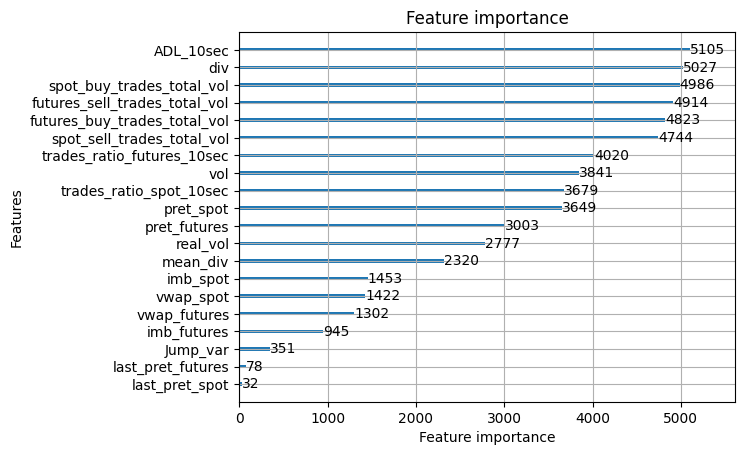

In [74]:
while True:
    try:
        lgbm_model_after_train(next(generator), init_model_name = 'model_lgbm_after_trained.txt',\
                                   saved_model_name = 'model_lgbm_after_trained.txt')
    except StopIteration:
        break